# 时间序列预测之ARIMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline
#plt.style.use('')

In [2]:
path='output/fileNo_8.csv'

df = pd.read_csv(path,keep_default_na=False) 
index=df["callTime_GMT"]

df=df.loc[df["competitorStatus"] == "ACTIVE"]

df=df.loc[df["inplay"] == False]
df[['bckPrc1']]= df[['bckPrc1']].astype(float)
df[['layPrc1']]= df[['layPrc1']].astype(float)
df[['bckSz1']]= df[['bckSz1']].astype(float)
df[['laySz1']]= df[['laySz1']].astype(float)

df[df.isnull().values==True]
ID = np.unique(df['selectionId'])
df=df.loc[df["selectionId"] == ID[0]]



df = df.sort_values('callTime_GMT')

In [3]:
np.mean(df[['bckPrc1']])

bckPrc1    22.384977
dtype: float64

In [4]:
ID 


array([ 6484261, 10354065, 11149841, 12154433, 12327645])

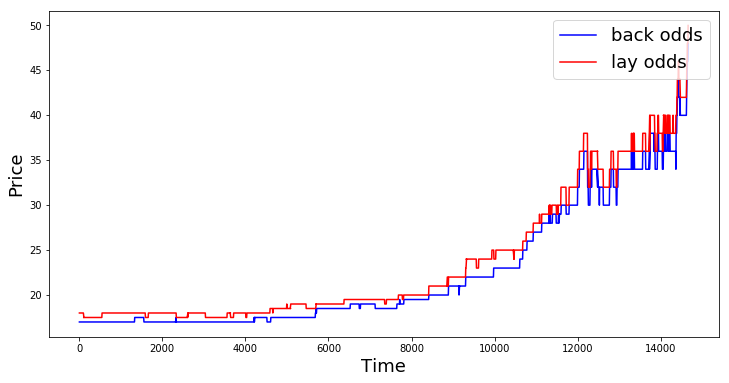

In [5]:
plt.figure(figsize = (12,6))
df["bckPrc1"].plot(color='b',label='back odds')
df["layPrc1"].plot(color='r',label='lay odds')

plt.xlabel('Time',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.legend(fontsize=18,loc = 'upper right')
plt.show
plt.show()

In [6]:

data = df.loc[:,["bckPrc1"]]


col_size = int(data.iloc[:,0].size)
cut_size = int(col_size*0.6)

data=data.iloc[:,0:1].values 


colSize = int(data[:,0].size)
cutSize = int(colSize*0.6)
testSize = int(colSize*0.2)



In [7]:
train_size = int(len(data) * 0.6)
test_size = int(len(data) * 0.4)
train, test = data[0:train_size], data[-test_size:]

In [8]:
ts=df['bckPrc1']
ts.head()

4     17.0
10    17.0
16    17.0
22    17.0
28    17.0
Name: bckPrc1, dtype: float64

In [9]:
ts.head().index

Int64Index([4, 10, 16, 22, 28], dtype='int64')

先给出平稳性统计检验函数，可以将一些结果直接展示出来。

In [10]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(60).mean()
 
    rolstd = timeseries.rolling(60).std()

    #Plot rolling statistics:
    plt.figure(figsize=(10,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

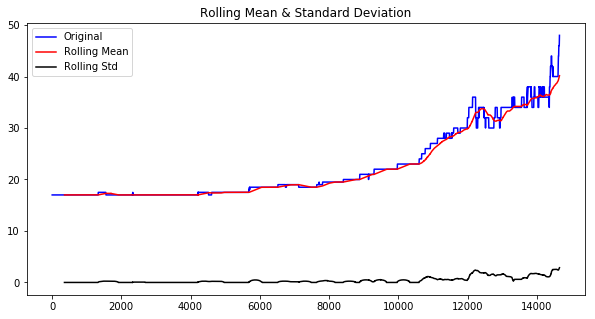

Results of Dickey-Fuller Test:
Test Statistic                    3.355188
p-value                           1.000000
#Lags Used                       27.000000
Number of Observations Used    2415.000000
Critical Value (1%)              -3.433061
Critical Value (5%)              -2.862738
Critical Value (10%)             -2.567408
dtype: float64


In [11]:
test_stationarity(ts)

这里的test statistic就是检验统计量，p-value是接受原假设的概率，一般情况下按照5%的置信区间去判断就可以。

上面的结果显示，p-value远大于0.05，而且检验统计量大于任何一个critical value，所以并不能拒绝原假设，即非平稳。

# 平稳性处理

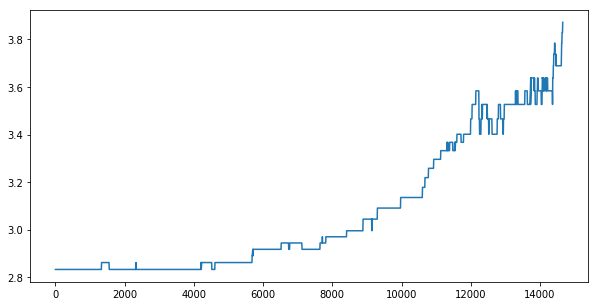

In [12]:
#对数转换

ts_log=np.log(ts)
plt.figure(figsize=(10,5))
plt.plot(ts_log)

In [13]:
#这个图看起来要好一些。Test statistic 比 1% Critical value 要小，而且p-value显著小于0.05，说明在99%置信区间内该序列是一个平稳序列。

#另外，有些情况下，合适的窗口值（如本例中的60）是不太好确定的，所以，可以采用加权移动平均，常用的主要是指数加权移动平均方法，Pandas中用ewma函数。

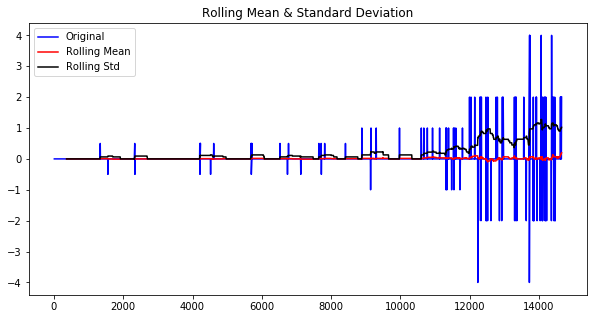

Results of Dickey-Fuller Test:
Test Statistic                -1.234964e+01
p-value                        5.864815e-23
#Lags Used                     2.700000e+01
Number of Observations Used    2.414000e+03
Critical Value (1%)           -3.433062e+00
Critical Value (5%)           -2.862738e+00
Critical Value (10%)          -2.567408e+00
dtype: float64


In [14]:
#差分——差分是剔除周期性因素的最常用方法
#一阶差分可以用Pandas的shift函数
ts_log_diff = ts - ts.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

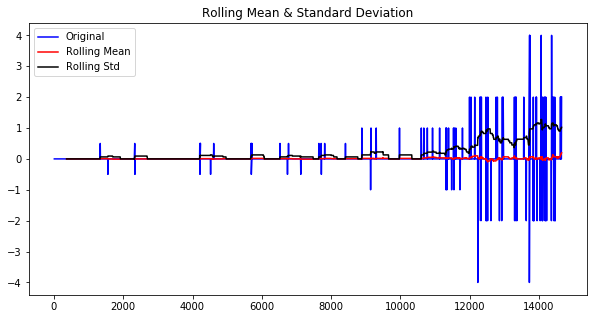

Results of Dickey-Fuller Test:
Test Statistic                -1.234964e+01
p-value                        5.864815e-23
#Lags Used                     2.700000e+01
Number of Observations Used    2.414000e+03
Critical Value (1%)           -3.433062e+00
Critical Value (5%)           -2.862738e+00
Critical Value (10%)          -2.567408e+00
dtype: float64


In [15]:
#另外一种方法做一阶差分
diff_1=ts.diff(1)
diff_1.dropna(inplace=True)
test_stationarity(diff_1)

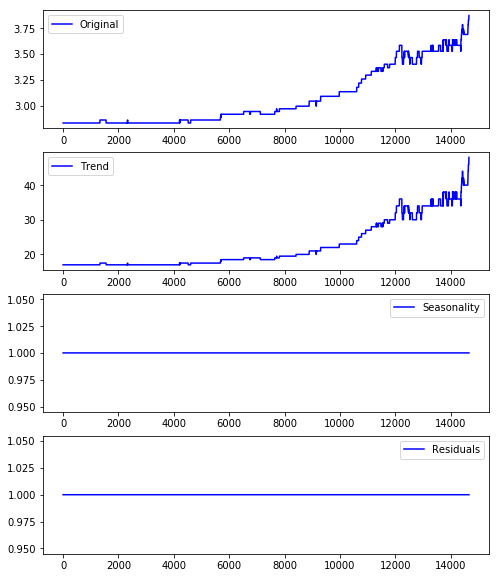

In [16]:
#分解——将时间序列数据分解成不同的成分，例如长期趋势、季节趋势和随机成分

decomposition=seasonal_decompose(ts,freq=1,model='multiplicative')
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

plt.figure(figsize=(8,10))
plt.subplot(411)
plt.plot(ts_log,label='Original',color='b')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend,label='Trend',color='b')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality',color='b')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual,label='Residuals',color='b')
plt.legend(loc='best')

上面把4种方法的具体处理程序都给出了，下面采用一阶差分的结果来建模。

Text(0.5,1,'Partial Autocorrelation Function')

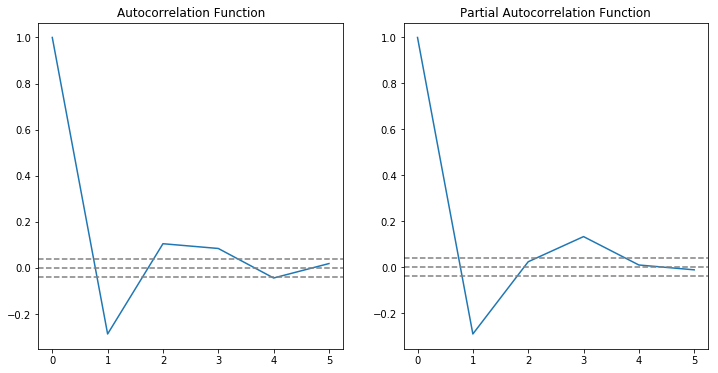

In [17]:
#采用ACF和PACF来确定参数p（AR）和q(MR)
lag_acf=acf(diff_1,nlags=5)
lag_pacf=pacf(diff_1,nlags=5,method='ols')

plt.figure(figsize=(12,6))
#plot_acf
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#plot_pacf
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

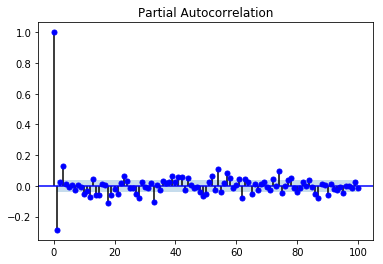

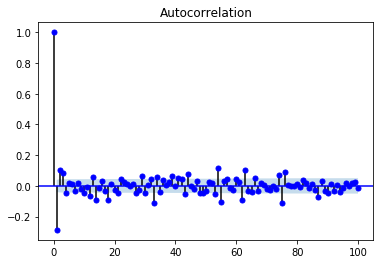

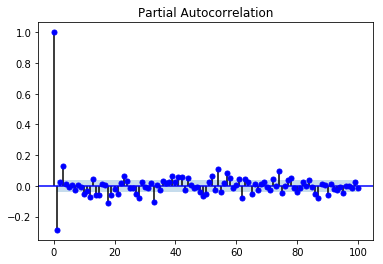

In [18]:
plot_acf(diff_1,lags=100,color='b')
plot_pacf(diff_1,lags=100,color='b')

/cs/home/fq4/tensorflow_venv/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 2160x1440 with 0 Axes>

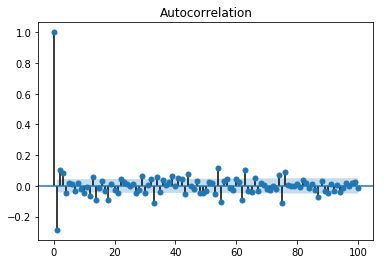

In [19]:
plt.figure(figsize = (30,20))


plot_acf(ts_log_diff,lags=100).show() 



/cs/home/fq4/tensorflow_venv/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 2160x1440 with 0 Axes>

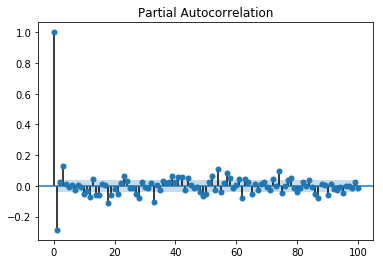

In [20]:
plt.figure(figsize = (30,20))


plot_pacf(ts_log_diff,lags=100).show() 



什么是截尾和拖尾？

（1）p阶自回归模型 AR(P) 
AR(p)模型的偏自相关函数PACF在p阶之后应为零，称其具有截尾性； 
AR(p)模型的自相关函数ACF不能在某一步之后为零（截尾），而是按指数衰减（或成正弦波形式)，称其具有拖尾性。

（2）q阶移动平均模型 MA(q) 
MA(q)模型的自相关函数ACF在q阶之后应为零，称其具有截尾性； 
MA(q)模型的偏自相关函数PACF不能在某一步之后为零（截尾），而是按指数衰减（或成正弦波形式)，称其具有拖尾性。

判断p和q的值

若都拖尾，得到ARMA(p，q)模型，自相关图有几个在两倍标准差之外就能确定p，偏自相关图突出两倍标准差的确定q。

从ACF和PACF图，可以看出p值为2，q值为2，然后之前做的一阶差分，所以d也为1。

下面就可以按照确定的参数进行模型构造了。

/cs/home/fq4/tensorflow_venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/cs/home/fq4/tensorflow_venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5,1,'RSS: 349.8787')

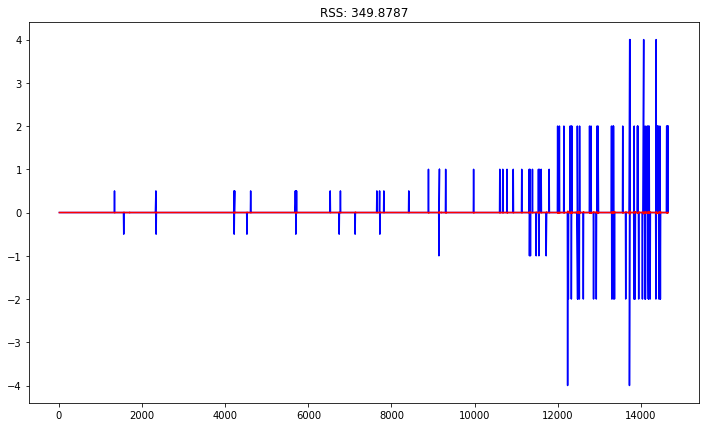

In [21]:
#模型构造
#AR模型

model=ARIMA(ts_log,order=(2,1,0))
results_AR=model.fit()
plt.figure(figsize=(12,7))
plt.plot(ts_log_diff,color='blue')
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

/cs/home/fq4/tensorflow_venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/cs/home/fq4/tensorflow_venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5,1,'RSS: 349.6461')

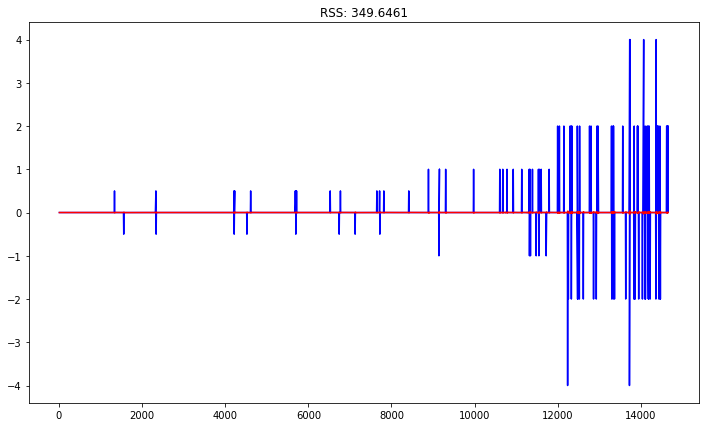

In [22]:
#MA 模型

model=ARIMA(ts_log,order=(0,1,2))
results_MA=model.fit()
plt.figure(figsize=(12,7))
plt.plot(ts_log_diff,color='blue')
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

In [23]:
len(ts)

2443

/cs/home/fq4/tensorflow_venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/cs/home/fq4/tensorflow_venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5,1,'RSS: 316.5961')

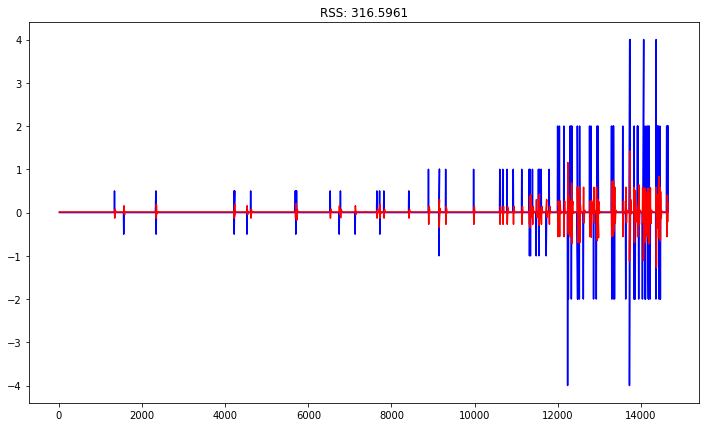

In [24]:
#ARIMA模型

model = ARIMA(ts, order=(0,1,3))
results_ARIMA = model.fit(disp=-50)  
plt.figure(figsize=(12,7))
plt.plot(ts_log_diff,color='blue')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))


In [25]:
#modelA = SARIMAX(train,order=(3,2,3))
#resA = modelA.fit()

#modelB = SARIMAX(test,order=(3,2,3))
#resB = modelB.smooth(resA.params)


In [26]:
#把所计算的结果转变为原来的尺度

predictions_ARIMA_diff=pd.Series(results_ARIMA.fittedvalues,copy=True)
predictions_ARIMA_diff.head()

10    0.012628
16    0.016259
22    0.015641
28    0.013894
34    0.013271
dtype: float64

In [27]:
predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()


In [28]:
ts.head()

4     17.0
10    17.0
16    17.0
22    17.0
28    17.0
Name: bckPrc1, dtype: float64

In [29]:
predictions_ARIMA_log=pd.Series(ts.ix[ts.index[0]], index=ts.index)


/cs/home/fq4/tensorflow_venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [30]:
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

MAE =  13.20557239541414
MAPE =  0.4814988602595219
R squared =  -4.35184314067276
RMSE: 13.1864


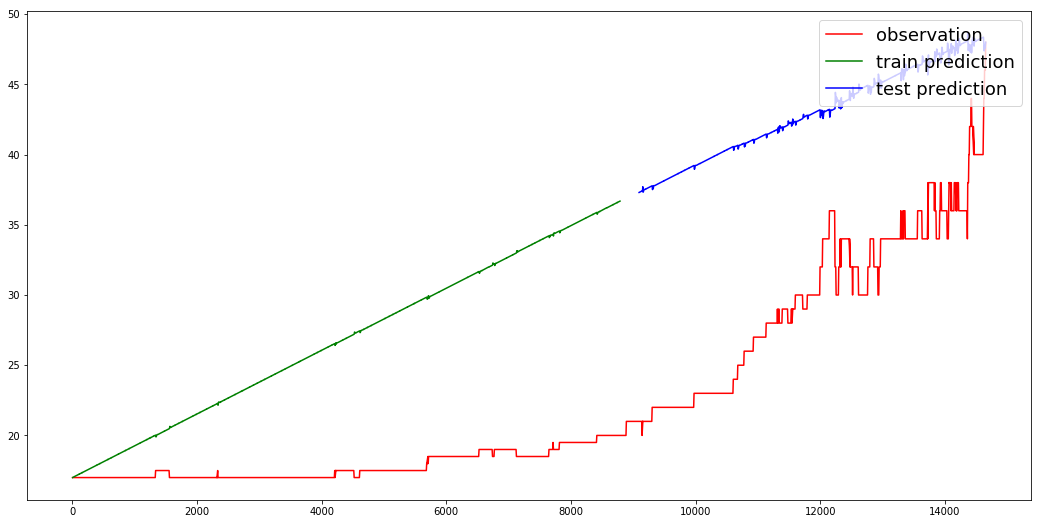

In [31]:
predictions_ARIMA=(predictions_ARIMA_log)
predictions_ARIMA = predictions_ARIMA.drop_duplicates( keep='last')

plt.figure(figsize=(18,9))
plt.plot(ts,color='r',label='observation')
plt.plot(predictions_ARIMA[0:train_size],color='green',label='train prediction')
plt.plot(predictions_ARIMA[train_size+50:],color='b',label='test prediction')
plt.legend(loc='upper right',fontsize=18)
testPredict1 = predictions_ARIMA[train_size+50:]
testY1 = ts[train_size+50:]
absError1 = abs(testPredict1-testY1)
print("MAE = ", sum(absError1) / len(absError1))
print("MAPE = ", sum(abs(absError1 /(testY1)))/len(absError1))
print("R squared = ", r2_score(ts[train_size+50:],predictions_ARIMA[train_size+50:]))
print ('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA[train_size+50:]-ts[train_size+50:])**2)/len(ts[train_size:])))

In [32]:
stats.pearsonr(testY1,testPredict1)


(0.9491719526995092, 0.0)

另外，也可以让模型来自行识别参数，下面这个函数就是整个过程。

In [33]:
def create_dataset(dataset, look_back=1):
    dataX, dataY =[],[] 
    for i in range(len(dataset)- look_back -1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX), np.array(dataY)

In [34]:
residual= pd.DataFrame(predictions_ARIMA-ts)

In [35]:


residual = residual.astype(float)

In [36]:
len(residual)

2443

In [37]:
residual.iloc[:,0:1].values 

array([[ 0.        ],
       [ 0.01262752],
       [ 0.02888633],
       ...,
       [ 1.56965988],
       [ 1.78663961],
       [-0.00263342]])

In [38]:
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(residual)

In [39]:
train_size = int(len(dataset) * 0.6)
test_size = int(len(dataset) * 0.4)
train, test = dataset[0:train_size], dataset[train_size:]

In [40]:
look_back = 50

In [41]:

trainX, trainY = create_dataset(train,look_back)
testX, testY = create_dataset(test, look_back)

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas import DataFrame
from pandas import Series
from pandas import concat
from math import sqrt
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers
import time



Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/cs/home/fq4/tensorflow_venv/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/cs/home/fq4/tensorflow_venv/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/cs/home/fq4/tensorflow_venv/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/usr/local/python/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/usr/local/python/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcublas.so.9.0: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], look_back, 1))

In [ ]:
testX = np.reshape(testX, (testX.shape[0], look_back,1))

In [ ]:
model = Sequential()

model.add(LSTM(input_dim=1,output_dim=120,return_sequences=False))
#model.add(Dropout(0.02))

#model.add(LSTM(16,return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(output_dim=1))
model.add(Activation('tanh'))

start=time.time()
model.compile(loss='mean_squared_error',optimizer='Adam')


history=model.fit(trainX,trainY,batch_size=len(residual),nb_epoch=60,validation_split=0.2,verbose=2)

print ('compilation time:',time.time()-start)


In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [ ]:
before=np.zeros((51, 1))

In [ ]:
predict= np.vstack((before,trainPredict,before,testPredict))

In [ ]:
len(predict)

In [ ]:
a=np.array(predictions_ARIMA)

In [ ]:

a.shape=(1,len(predict))

y=np.transpose(a)

In [ ]:
len(trainPredict)

In [ ]:
len(y)

In [ ]:
final = -predict+y

In [ ]:
len(final)

In [ ]:
a = np.arange(train_size)

In [ ]:
b = np.arange(train_size+51,len(data))

In [ ]:
final

In [ ]:
plt.figure(figsize=(18,9))
plt.plot(data,color='r',label='observation')

plt.plot(a,final[0:train_size],color='green',label='train prediction')
plt.plot(b,final[train_size+51:],color='b',label='test prediction')

plt.legend(loc='upper right',fontsize=18)


In [ ]:


print ('RMSE: %.4f'% np.sqrt(sum((final[train_size+50:]-data[train_size+50:])**2)/train_size))

In [ ]:

absError = abs(testPredict-testY)
print("MAE = ", sum(absError) / len(absError))

In [ ]:
print("R squared = ", r2_score(ts[train_size+50:],final[train_size+50:]))

In [ ]:
a1= final[train_size+50:train_size+100]

In [ ]:
b1= data[train_size+50:train_size+100]

In [ ]:
s1= np.where(a1==np.max(a1))

In [ ]:
b1[s1]

In [ ]:
len(data)*0.4

In [ ]:
a2= final[train_size+100:train_size+150]
b2= data[train_size+100:train_size+150]
s2= np.where(a2==np.max(a2))
b2[s2]

In [ ]:
a3= final[train_size+150:train_size+200]
b3= data[train_size+150:train_size+200]
s3= np.where(a3==np.max(a3))
b3[s3]

In [ ]:
for i in range(20):
    a2= final[train_size+50*i:train_size+50*(i+1)]
    b2= data[train_size+50*i:train_size+50*(i+1)]
    s2= np.where(a2==np.min(a2))
    print (b2[s2])

In [ ]:
for i in range(20):
    a2= final[train_size+50*i:train_size+50*(i+1)]
    b2= data[train_size+50*i:train_size+50*(i+1)]
    s2= np.where(a2==np.min(a2))
    print (a2[s2])
    